In [ ]:
#!pip install statsmodels

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Cargar datos y otros análisis

In [3]:
jara = pd.read_csv('./data/jara_processed.csv').set_index('date')
pena = pd.read_csv('./data/pena_processed.csv').set_index('date')
minon = pd.read_csv('./data/minon_processed.csv').set_index('date')

In [5]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

def split_data(df, train_ratio, val_ratio, test_ratio):
    df = df.sort_index()

    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    test_size = len(df) - train_size - val_size

    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    return train_df, val_df, test_df

jara_train, jara_val, jara_test = split_data(jara, train_ratio, val_ratio, test_ratio)
pena_train, pena_val, pena_test = split_data(pena, train_ratio, val_ratio, test_ratio)
minon_train, minon_val, minon_test = split_data(minon, train_ratio, val_ratio, test_ratio)


Con las correlaciones totales y parciales podemos detectar que se mantiene una correlación alta hasta 24 horas atrás. Esto nos puede ayudar a decidir la ventana de contexto que utilicemos para entrenar los diferentes modelos.

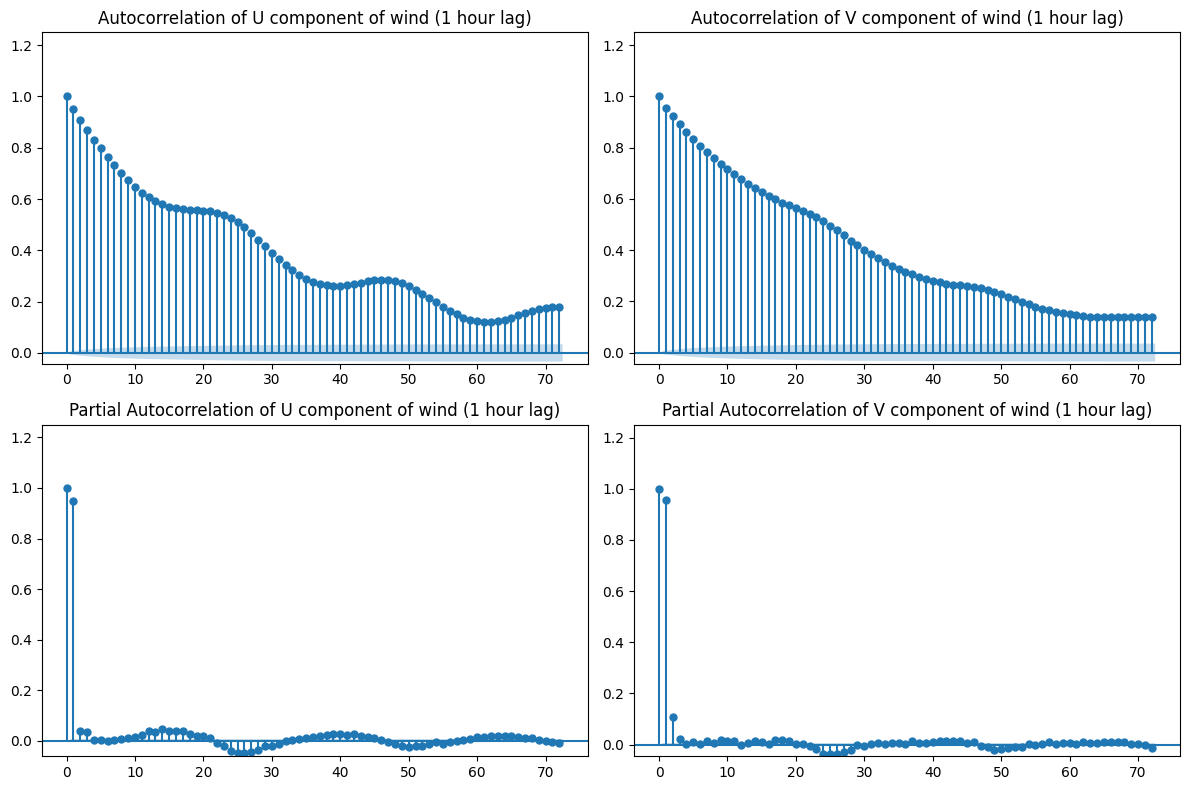

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

plot_acf(jara['U'], lags=72, auto_ylims=True, ax=axes[0, 0], title='Autocorrelation of U component of wind (1 hour lag)')
plot_acf(jara['V'], lags=72, auto_ylims=True, ax=axes[0, 1], title='Autocorrelation of V component of wind (1 hour lag)')
plot_pacf(jara['U'], lags=72, auto_ylims=True, method='ywm', ax=axes[1, 0], title='Partial Autocorrelation of U component of wind (1 hour lag)')
plot_pacf(jara['V'], lags=72, auto_ylims=True, method='ywm', ax=axes[1, 1], title='Partial Autocorrelation of V component of wind (1 hour lag)')

plt.tight_layout()
plt.show()


## Baseline

Como primera baseline para comparar nuestros modelos utilizaremos persistencia sobre un horizonte de predicción de 12 h.

In [11]:
# Implementar la baseline de persistencia
def persistence_baseline(data, horizon):
    predictions = []
    true_values = []
    for i in range(len(data) - horizon):
        last_value = data.iloc[i]
        pred = [last_value] * horizon
        predictions.append(pred)
        true_values.append(data.iloc[i+1:i+horizon+1].values)
    return np.array(predictions), np.array(true_values)

# Evaluar el rendimiento de la baseline
def evaluate_performance(predictions, true_values):
    mse_scores = []
    for i in range(predictions.shape[1]):
        mse = mean_squared_error(true_values[:, i], predictions[:, i])
        mse_scores.append(mse)
    return mse_scores


In [22]:
horizon = 12

for dataset_name, dataset in [('jara', jara_test), ('pena', pena_test), ('minon', minon_test)]:
    predictions_U, true_values_U = persistence_baseline(dataset['U'], horizon)
    predictions_V, true_values_V = persistence_baseline(dataset['V'], horizon)

    mse_U = evaluate_performance(predictions_U, true_values_U)
    mse_V = evaluate_performance(predictions_V, true_values_V)

    print(f"Resultados para {dataset_name}:")
    print(f"Errores MSE para U: {np.mean(mse_U):.2f} {mse_U}")
    print(f"Errores MSE para V: {np.mean(mse_V):.2f} {mse_V}")


Resultados para jara:
Errores MSE para U: 0.47 [0.10230539285516575, 0.1890281158901961, 0.2610199478582012, 0.33260435016026174, 0.4003816471872532, 0.4643920782973107, 0.5242742475037213, 0.5813289631260284, 0.6343159427293781, 0.6816932002514274, 0.720759228455777, 0.7550545533569731]
Errores MSE para V: 0.37 [0.0967308439324283, 0.15717234183445253, 0.2115677020181572, 0.2689517813364556, 0.3119841622761421, 0.3611484717955262, 0.40929774915791134, 0.4524899587345736, 0.49177818768210796, 0.5230902679713254, 0.5553940023013346, 0.5897211787684835]
Resultados para pena:
Errores MSE para U: 1.06 [0.68228016396843, 0.7762825969151521, 0.8610405201757492, 0.9439300272355069, 1.0090357327155384, 1.0710768607146373, 1.1288533331939463, 1.1800239196752433, 1.2284642317761703, 1.250691301931634, 1.2735917494906699, 1.2929318526253242]
Errores MSE para V: 0.69 [0.296351645756906, 0.40748056708216096, 0.4839607986667687, 0.5559767961195763, 0.6230174365463129, 0.6863985901225856, 0.749042482